In [3]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q,approx_q_independent,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [4]:
lags = np.array([10,20,30,40,50,100])
vr_rates_dep = []
vr_rates_indep = []

In [70]:
N_burn = 1*10**4 # Burn in period\n",
N_train = 5*10**4 # Number of samples on which we optimize\n"
N_test = 2*10**3 # Number of samples\n",
step = 0.1 # Step size\n",
n_traj_train = 10
n_traj_test = 24 # Number of independent MCMC trajectories for test\n",
f_type = "sum"
K_max = 1 #max degree of Hermite polynomial\n",
S_max = 1 #max degree of polynomial during regression stage\n",
lag = 60 #maximal lag order\n",
b_n_train = 20 #lag-window size\n",
b_n_test = int(np.round(N_test**(0.33)))
print(b_n_test)
degree = 2

12


In [71]:
d = 2
mu = 0.5*np.array([1.0,1.0],dtype = float)
#mu_1 = np.array([-1.0])
#mu_2 = np.array([1.0])
#Sigma_1 = np.array([[1.0]])
#Sigma_2 = np.array([[1.0]])
Sigma = GenerateSigma(d,rand_seed = 777,eps = 0.1) #covariation matrix 
p = 0.5
#Cur_pot = GausMixtureSame(Sigma,mu,p)
#Cur_pot = GaussMixture(Sigma_1,Sigma_2,mu_1,mu_2,p)
Cur_pot = GausMixtureIdent(mu,p)
r_seed = 777
x0 = np.array([0.0,0.0])
fixed_start = True

[1.94283271 0.1       ]


Choose sampler type (currently only ULA is maintained)

### Generate data

In [72]:
r_seed = 777
traj = np.zeros((n_traj_train,N_train,d),dtype = float)
for i in range(n_traj_train):
    cur_traj = ULA_light(r_seed+i,Cur_pot,step, N_burn, N_train, d, return_noise = False, x0 = x0, fixed_start = fixed_start)
    traj[i] = copy.deepcopy(cur_traj)
print(traj.shape)

(10, 50000, 2)


In [73]:
inds_arr = np.array([1]) # Taking the second index (not intercept)
params = None    
f_vals = set_function(f_type,traj,inds_arr,params) 
#f_vals = traj[:,:,0]
#f_vals = np.expand_dims(f_vals, axis=2)
print(f_vals.shape)

(10, 50000, 1)


In [74]:
n_traj_train_adv = 1*10**5
r_seed = 7771453
traj_adv = np.zeros((n_traj_train_adv,lag,d),dtype = float)
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(ULA_light, [(r_seed+i,Cur_pot,step, 100, lag, d, False,x0, False) for i in range (n_traj_train_adv)])
trav.close()

In [75]:
traj_adv = np.zeros((n_traj_train_adv,lag,d),dtype = float)
for i in range(n_traj_train_adv):
    traj_adv[i] = copy.deepcopy(res[i])
print(traj_adv.shape)
inds_arr = np.array([0]) # Taking the second index (not intercept)
params = None  
f_vals_adv = set_function(f_type,traj_adv,inds_arr,params)
print(f_vals_adv.shape)

(100000, 60, 2)
(100000, 60, 1)


### Evaluate baselines (EVM and ESVM methods)

In [ ]:
sampler = {"sampler":"ULA","burn_type":"full","main_type":"full"} # Sampling method

if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj_train, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj_evm,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    raise "You should use ULA!"

In [ ]:
print(traj.shape)
inds_arr = np.array([0])#Taking the second index
params = None
f_vals_evm = set_function(f_type,traj_evm,inds_arr,params)

In [ ]:
print(f_vals_evm)
print(f_vals)

In [ ]:
W_train_spec = construct_ESVM_kernel(N_train,b_n_train) #weight matrix for train
W_test_spec = construct_ESVM_kernel(N_test,b_n_test) #weight matrix for test
opt_structure_train = {
    "W":W_train_spec,
    "n_restarts": 3, # Number of restarts during optimization,
    "sigma": 1.0, # Deviation of starting points
    "tol": 1e-5, # Tolerance (for the norm of gradient)
    "alpha": 0.0, # Ridge penalty for 2nd order control functionals
    "beta": 10000.0 # smoothing parameter in the softmax
}
methods = ["ESVM","EVM"]

In [ ]:
coef_dict = optimize_parallel_new(degree,inds_arr,f_vals_evm,traj_evm,traj_grad,opt_structure_train,methods)
print(coef_dict)

In [ ]:
#Create a dictionary and put respective matrices into it
test_params = {
    "W":W_test_spec,
    "step":step,
    "burn_in":N_burn,
    "n_test":N_test,
    "dim":d
}

nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Run_eval_test, [(i,degree,sampler,methods,inds_arr,Cur_pot,test_params,coef_dict,params,f_type) for i in range (n_traj_test)])
trav.close()

In [ ]:
methods_enh = ['Vanilla'] + methods
print(methods_enh)
ints_result = {key: [] for key in methods_enh}
vars_result = {key: [] for key in methods_enh}

In [ ]:
for i in range(len(res)):
    for j in range(len(methods_enh)):
        ints_result[methods_enh[j]].append(res[i][0][methods_enh[j]][0])
        vars_result[methods_enh[j]].append(res[i][1][methods_enh[j]][0])
for key in methods_enh:
    ints_result[key] = np.asarray(ints_result[key])
    vars_result[key] = np.asarray(vars_result[key])

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [76]:
#polynomial coefficients
coefs_poly = approx_q(traj,f_vals,n_traj_train,lag,S_max)
print(coefs_poly.shape)

dimension =  50000
variance:  3.1343249336286108
[ 0.          1.10603779  0.88668577  0.40044105  1.06224106  1.26465018
  0.89961616  0.59352086 -0.48939963 -0.30294844  0.2246467   0.52351515
  0.07270428  0.47244167 -0.08402563 -0.02553797 -1.20757209 -1.47206108
 -1.95878644 -2.47608404 -1.93106759 -0.75339685  0.3759221   0.04118303
  0.62245741  0.55313871  0.5765249   0.58595653 -0.77089444 -0.8915072
 -0.07792988  0.54436348  0.3972778   0.35052883  0.50404559  1.36911617
  2.13356538  2.01157709  2.60525598  2.60702052  2.08229245  2.46281425
  2.2867142   2.13361178  1.90080811  1.48537597  1.11506194  1.67063612
  1.04028555  1.05324386]
(500000, 3)
variance:  3.1343876157033237
[ 1.10603779  0.88668577  0.40044105  1.06224106  1.26465018  0.89961616
  0.59352086 -0.48939963 -0.30294844  0.2246467   0.52351515  0.07270428
  0.47244167 -0.08402563 -0.02553797 -1.20757209 -1.47206108 -1.95878644
 -2.47608404 -1.93106759 -0.75339685  0.3759221   0.04118303  0.62245741
  0.5531

variance:  3.1347608287174586
[-0.08402563 -0.02553797 -1.20757209 -1.47206108 -1.95878644 -2.47608404
 -1.93106759 -0.75339685  0.3759221   0.04118303  0.62245741  0.55313871
  0.5765249   0.58595653 -0.77089444 -0.8915072  -0.07792988  0.54436348
  0.3972778   0.35052883  0.50404559  1.36911617  2.13356538  2.01157709
  2.60525598  2.60702052  2.08229245  2.46281425  2.2867142   2.13361178
  1.90080811  1.48537597  1.11506194  1.67063612  1.04028555  1.05324386
  1.20004166  1.01313113  0.39167999  0.70462606 -0.31874899 -0.15565284
 -0.7430719  -0.16024652  0.27407608  0.47606999  0.02906979 -0.19597203
 -1.04907982 -1.17410028]
(499860, 3)
variance:  3.1347541524392537
[-0.02553797 -1.20757209 -1.47206108 -1.95878644 -2.47608404 -1.93106759
 -0.75339685  0.3759221   0.04118303  0.62245741  0.55313871  0.5765249
  0.58595653 -0.77089444 -0.8915072  -0.07792988  0.54436348  0.3972778
  0.35052883  0.50404559  1.36911617  2.13356538  2.01157709  2.60525598
  2.60702052  2.08229245  2.

(499700, 3)
variance:  3.1347126106045393
[ 0.54436348  0.3972778   0.35052883  0.50404559  1.36911617  2.13356538
  2.01157709  2.60525598  2.60702052  2.08229245  2.46281425  2.2867142
  2.13361178  1.90080811  1.48537597  1.11506194  1.67063612  1.04028555
  1.05324386  1.20004166  1.01313113  0.39167999  0.70462606 -0.31874899
 -0.15565284 -0.7430719  -0.16024652  0.27407608  0.47606999  0.02906979
 -0.19597203 -1.04907982 -1.17410028 -0.4903145   0.42036387  1.1076787
  1.40501511  0.35890844 -0.72543865 -2.16201853 -1.80293504 -1.92963558
 -1.22846094 -1.12980896 -0.43620596 -0.9126322  -1.00937618 -1.28107667
 -1.39490862 -2.121166  ]
(499690, 3)
variance:  3.134731290824941
[ 0.3972778   0.35052883  0.50404559  1.36911617  2.13356538  2.01157709
  2.60525598  2.60702052  2.08229245  2.46281425  2.2867142   2.13361178
  1.90080811  1.48537597  1.11506194  1.67063612  1.04028555  1.05324386
  1.20004166  1.01313113  0.39167999  0.70462606 -0.31874899 -0.15565284
 -0.7430719  -0.1

variance:  3.134922067403923
[ 1.67063612  1.04028555  1.05324386  1.20004166  1.01313113  0.39167999
  0.70462606 -0.31874899 -0.15565284 -0.7430719  -0.16024652  0.27407608
  0.47606999  0.02906979 -0.19597203 -1.04907982 -1.17410028 -0.4903145
  0.42036387  1.1076787   1.40501511  0.35890844 -0.72543865 -2.16201853
 -1.80293504 -1.92963558 -1.22846094 -1.12980896 -0.43620596 -0.9126322
 -1.00937618 -1.28107667 -1.39490862 -2.121166   -2.25301699 -2.37381792
 -2.19758302 -2.77987121 -2.82358029 -3.07046597 -2.67964135 -1.5477534
 -1.37996698  1.23587834  0.16115508  0.08731289 -1.0957749  -0.80618524
  0.19532862 -0.11627863]
(499530, 3)
variance:  3.134934175726539
[ 1.04028555  1.05324386  1.20004166  1.01313113  0.39167999  0.70462606
 -0.31874899 -0.15565284 -0.7430719  -0.16024652  0.27407608  0.47606999
  0.02906979 -0.19597203 -1.04907982 -1.17410028 -0.4903145   0.42036387
  1.1076787   1.40501511  0.35890844 -0.72543865 -2.16201853 -1.80293504
 -1.92963558 -1.22846094 -1.129

In [77]:
coefs_poly_indep = approx_q_independent(traj_adv,f_vals_adv,n_traj_train_adv,lag,S_max)
print(coefs_poly.shape)

dimension =  60
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(100000, 3)
(60, 3)


### Use theoretically computed coefficients in regression

In [ ]:
print(coefs_poly.shape)
print(coefs_poly)
coefs_poly_theor = np.zeros_like(coefs_poly)
for ind in range(len(coefs_poly_theor)):
    if ind == 0:
        coefs_poly_theor[ind,0] = 0
    else:
        coefs_poly_theor[ind,0] = d*(1-(1-step)**(2*ind))/(1-step/2)   
    coefs_poly_theor[ind,3] = (1-step)**(2*ind)
    coefs_poly_theor[ind,5] = (1-step)**(2*ind)

Test our regressors

In [ ]:
cur_lag = 1
N_pts = 100
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(traj[0,cur_lag:N_pts],color='r',label='true function')
plt.plot(P.polynomial.polyval(traj[0,:N_pts-cur_lag],coefs_poly[cur_lag,:]),color='g',label = 'practical approximation')
#plt.plot(P.polynomial.polyval(X_train[0,:N_pts-cur_lag],coefs_poly_theor[cur_lag,:]),color='b',label = 'theoretical approximation')
plt.legend(loc = 'lower right',fontsize = 16)
plt.show()

In [78]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_dep = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


In [79]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_indep = trav.starmap(test_traj, [(Cur_pot,coefs_poly_indep,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


In [80]:
res_new_dep = np.asarray(res_dep)
res_new_indep = np.asarray(res_indep)

In [81]:
vars_vanilla_dep = np.var(res_new_dep[:,0,:],axis = 0)
vars_adj_dep = np.var(res_new_dep[:,1,:],axis = 0)
vr_rate_dep = vars_vanilla_dep[-1]/vars_adj_dep[-1]
print(vr_rate_dep)

vars_vanilla_indep = np.var(res_new_indep[:,0,:],axis = 0)
vars_adj_indep = np.var(res_new_indep[:,1,:],axis = 0)
vr_rate_indep = vars_vanilla_indep[-1]/vars_adj_indep[-1]
print(vr_rate_indep)

347.15035631405135
342.0924045029409


In [82]:
vr_rates_dep.append(vr_rate_dep)
vr_rates_indep.append(vr_rate_indep)

In [86]:
print(vr_rates_dep)

[3.9359364656363818, 15.526144431687205, 56.597258311797674, 157.03703570762943, 279.0304865349766, 347.15035631405135]


In [91]:
vr_rates_dep = np.asarray(vr_rates_dep)
vr_rates_indep = np.asarray(vr_rates_indep)
print(vr_rates_dep.shape)

(6,)


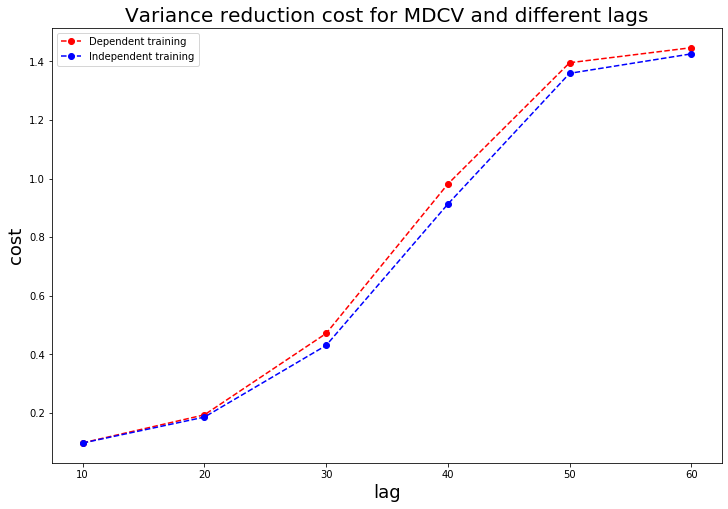

In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
lags_cur = np.array([10,20,30,40,50,60])
# add grid
# plot the index for the x-values
plt.plot(lags_cur,vr_rates_dep/(lags_cur*4), marker='o', linestyle='--', color='r', label='Dependent training') 
plt.plot(lags_cur,vr_rates_indep/(lags_cur*4), marker='o', linestyle='--', color='b', label='Independent training') 
plt.xlabel('lag',fontsize = 18)
plt.ylabel('cost',fontsize = 18) 
plt.title('Variance reduction cost for MDCV and different lags',fontsize = 20)
plt.legend() 
plt.show()

### Comparison plots

In [ ]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith MDCV', 'ULA \nwith EVM','ULA\nwith ESVM']

In [ ]:
data = [ints_result['Vanilla'][:,0],res_new[:,1,-1],ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['ULA \nwith MDCV', 'ULA \nwith EVM','ULA\nwith ESVM']

In [ ]:
data = [res_new[:,1,-1],ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)